<a href="https://colab.research.google.com/github/piaosan78/AIFFEL_Quest/blob/master/MQ4/MQ4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [27]:
from google.colab import drive             # 구글 드라이브 마운트
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
%cd /content/drive/MyDrive/X_ray_chest

!unzip -qq "/content/drive/MyDrive/chest_xray.zip"

/content/drive/MyDrive/X_ray_chest
replace __MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [29]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE                              # 오토튠 변수 지정
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = '/content/drive/MyDrive/X_ray_chest'                    # 루트 경로 지정
TRAIN_PATH = os.path.join(ROOT_PATH, 'train/*/*')                   # 루트 경로의 각 폴더 지정하여 변수 설정
VAL_PATH = os.path.join(ROOT_PATH, 'val/*/*')
TEST_PATH = os.path.join(ROOT_PATH, 'test/*/*')

print(ROOT_PATH)

/content/drive/MyDrive/X_ray_chest


In [30]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

17593
1226
1181


In [31]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

15019
3755


In [32]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/content/drive/MyDrive/X_ray_chest/train/PNEUMONIA/person1314_virus_2269.jpeg
Pneumonia image path
/content/drive/MyDrive/X_ray_chest/train/PNEUMONIA/person306_bacteria_1439_jpeg.rf.bd5ca1a607006d5e9866e201fb260b31.jpg


In [33]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 4034
Pneumonia images count in training set: 10985


In [34]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [35]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 15019
Validating images count: 3755


In [36]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [37]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [38]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [39]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [40]:
# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

In [41]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

1226


In [42]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

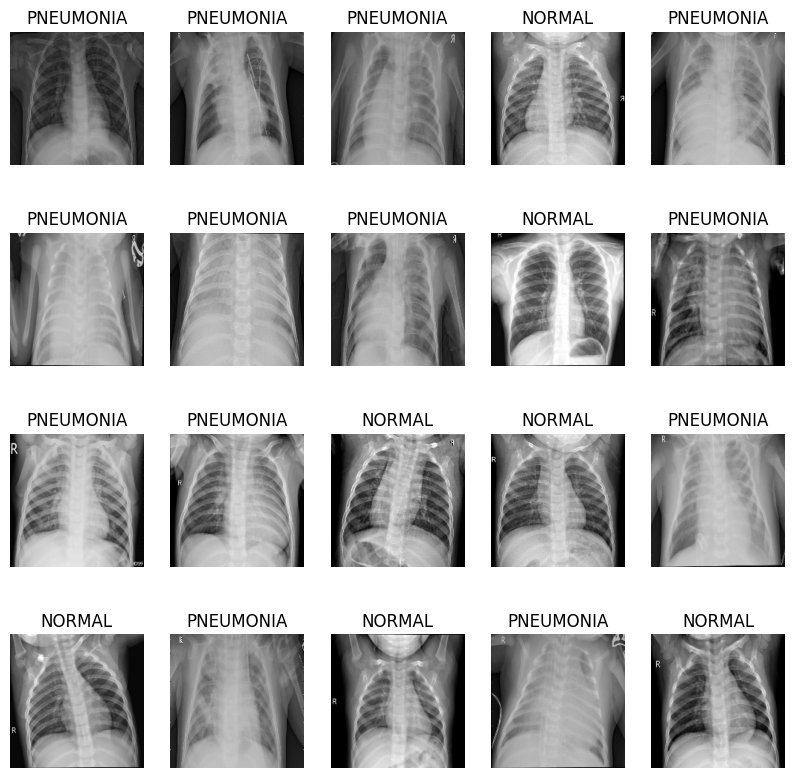

In [43]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [49]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, MaxPooling2D

def residual_block_without_bn(x, filters, kernel_size=3, stride=1):
    # Shortcut
    shortcut = x

    # First convolution layer
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = ReLU()(x)

    # Second convolution layer
    x = Conv2D(filters, kernel_size, strides=1, padding='same')(x)

    # Adjusting the shortcut for addition if needed
    if stride != 1 or x.shape[-1] != shortcut.shape[-1]:
        shortcut = Conv2D(filters, 1, strides=stride, padding='same')(shortcut)

    # Adding the shortcut to the output
    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

def build_resnet18_without_bn(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Residual blocks
    x = residual_block_without_bn(x, 64)
    x = residual_block_without_bn(x, 64)
    x = residual_block_without_bn(x, 128)
    x = residual_block_without_bn(x, 128)
    x = residual_block_without_bn(x, 256)
    x = residual_block_without_bn(x, 256)
    x = residual_block_without_bn(x, 512)
    x = residual_block_without_bn(x, 512)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')(x)

    model_without_bn = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model_without_bn

# ResNet-18 모델 (배치 정규화 제거) 생성
resnet18_model_without_bn = build_resnet18_without_bn((180, 180, 3), 1)
resnet18_model_without_bn.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_40 (Conv2D)             (None, 90, 90, 64)   9472        ['input_3[0][0]']                
                                                                                                  
 re_lu_34 (ReLU)                (None, 90, 90, 64)   0           ['conv2d_40[0][0]']              
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 45, 45, 64)  0           ['re_lu_34[0][0]']         

In [ ]:
from tensorflow.keras.utils import plot_model

# 모델 구조 시각화
plot_model(resnet18_model, to_file='resnet18_model.png', show_shapes=True, show_layer_names=True)

In [51]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.86
Weight for PNEUMONIA: 0.68


In [52]:
from tensorflow.keras.optimizers import Adam
with tf.device('/GPU:0'):
    model = build_resnet18((180, 180, 3), 1)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    learning_rate = 0.001

    adam_optimizer = Adam(learning_rate=learning_rate)

    model.compile(
        optimizer= adam_optimizer,
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [53]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
750/750 [==============================] - 57s 55ms/step - loss: 0.2626 - accuracy: 0.8976 - precision: 0.9639 - recall: 0.8935 - val_loss: 1.7068 - val_accuracy: 0.3799 - val_precision: 0.9449 - val_recall: 0.1628
Epoch 2/10
750/750 [==============================] - 40s 54ms/step - loss: 0.1628 - accuracy: 0.9355 - precision: 0.9767 - recall: 0.9340 - val_loss: 0.3323 - val_accuracy: 0.8602 - val_precision: 0.9938 - val_recall: 0.8141
Epoch 3/10
750/750 [==============================] - 40s 54ms/step - loss: 0.1325 - accuracy: 0.9508 - precision: 0.9832 - recall: 0.9490 - val_loss: 0.4816 - val_accuracy: 0.7928 - val_precision: 0.9930 - val_recall: 0.7221
Epoch 4/10
750/750 [==============================] - 40s 53ms/step - loss: 0.1240 - accuracy: 0.9508 - precision: 0.9824 - recall: 0.9498 - val_loss: 0.6251 - val_accuracy: 0.7869 - val_precision: 0.9964 - val_recall: 0.7115
Epoch 5/10
750/750 [==============================] - 40s 53ms/step - loss: 0.1109 - accuracy: 0

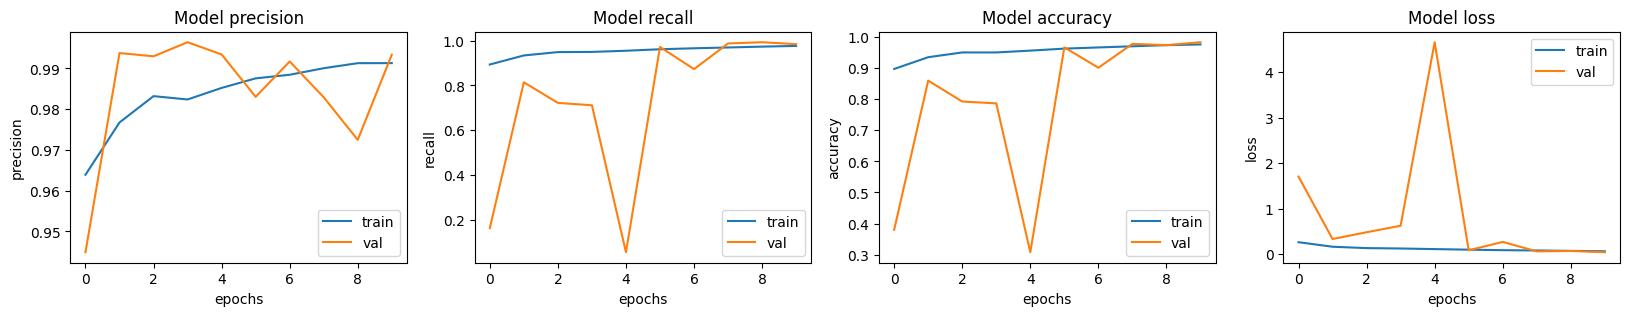

In [55]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

62/62 [==============================] - 2s 28ms/step - loss: 0.1281 - accuracy: 0.9584 - precision: 0.9594 - recall: 0.9793
Loss: 0.12811335921287537,
Accuracy: 0.9584013223648071,
Precision: 0.9594271779060364,
Recall: 0.9792935252189636


In [56]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, MaxPooling2D


# 배치 정규화 넣은 상태

def residual_block(x, filters, kernel_size=3, stride=1):
    # Shortcut
    shortcut = x

    # First convolution layer
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolution layer
    x = Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Adjusting the shortcut for addition if needed
    if stride != 1 or x.shape[-1] != shortcut.shape[-1]:
        shortcut = Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Adding the shortcut to the output
    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

def build_resnet18(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Residual blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)
    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# ResNet-18 모델 생성
resnet18_model = build_resnet18((180, 180, 3), 1)
resnet18_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_80 (Conv2D)             (None, 90, 90, 64)   9472        ['input_5[0][0]']                
                                                                                                  
 batch_normalization_60 (BatchN  (None, 90, 90, 64)  256         ['conv2d_80[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [57]:
from tensorflow.keras.optimizers import Adam
with tf.device('/GPU:0'):
    model = build_resnet18((180, 180, 3), 1)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    learning_rate = 0.001

    adam_optimizer = Adam(learning_rate=learning_rate)

    model.compile(
        optimizer= adam_optimizer,
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [58]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
750/750 [==============================] - 56s 54ms/step - loss: 0.2353 - accuracy: 0.9057 - precision: 0.9671 - recall: 0.9017 - val_loss: 6.0724 - val_accuracy: 0.2853 - val_precision: 0.9853 - val_recall: 0.0245
Epoch 2/10
750/750 [==============================] - 40s 53ms/step - loss: 0.1509 - accuracy: 0.9410 - precision: 0.9793 - recall: 0.9392 - val_loss: 3.1899 - val_accuracy: 0.3227 - val_precision: 1.0000 - val_recall: 0.0749
Epoch 3/10
750/750 [==============================] - 40s 53ms/step - loss: 0.1308 - accuracy: 0.9489 - precision: 0.9827 - recall: 0.9467 - val_loss: 0.3979 - val_accuracy: 0.8321 - val_precision: 0.9967 - val_recall: 0.7734
Epoch 4/10
750/750 [==============================] - 40s 54ms/step - loss: 0.1055 - accuracy: 0.9601 - precision: 0.9858 - recall: 0.9593 - val_loss: 0.2078 - val_accuracy: 0.9187 - val_precision: 0.9931 - val_recall: 0.8952
Epoch 5/10
750/750 [==============================] - 40s 53ms/step - loss: 0.0974 - accuracy: 0

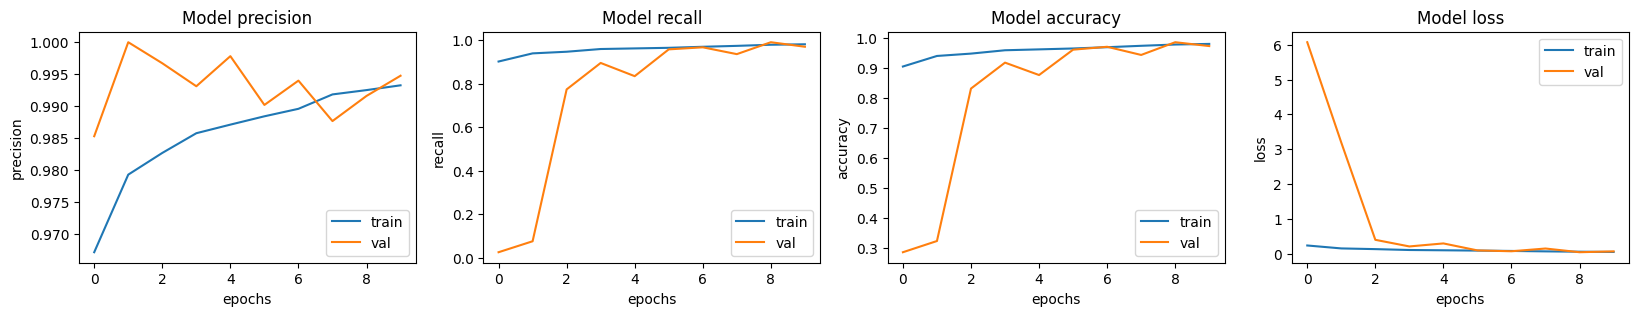

In [59]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [60]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

62/62 [==============================] - 2s 24ms/step - loss: 0.1010 - accuracy: 0.9649 - precision: 0.9664 - recall: 0.9817
Loss: 0.10101824253797531,
Accuracy: 0.9649266004562378,
Precision: 0.9664268493652344,
Recall: 0.9817296266555786


In [76]:
# 테스트 데이터셋 로드
# 원래의 Keras 모델 생성 및 컴파일
from tensorflow.keras.metrics import Precision, Recall

original_model = create_model()
original_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 모델 학습
original_model.fit(train_ds, epochs=10, validation_data=val_ds, steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE, validation_steps=VAL_IMG_COUNT // BATCH_SIZE)

# 모델 성능 평가
loss, accuracy = original_model.evaluate(test_ds, steps=TEST_IMG_COUNT // BATCH_SIZE)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/10
750/750 [==============================] - 57s 55ms/step - loss: 0.2011 - accuracy: 0.9215 - val_loss: 0.2181 - val_accuracy: 0.9120
Epoch 2/10
750/750 [==============================] - 41s 54ms/step - loss: 0.1267 - accuracy: 0.9521 - val_loss: 0.2039 - val_accuracy: 0.9345
Epoch 3/10
750/750 [==============================] - 40s 54ms/step - loss: 0.1012 - accuracy: 0.9630 - val_loss: 0.1652 - val_accuracy: 0.9441
Epoch 4/10
750/750 [==============================] - 41s 54ms/step - loss: 0.0879 - accuracy: 0.9680 - val_loss: 0.1614 - val_accuracy: 0.9382
Epoch 5/10
750/750 [==============================] - 41s 54ms/step - loss: 0.0829 - accuracy: 0.9686 - val_loss: 0.1024 - val_accuracy: 0.9639
Epoch 6/10
750/750 [==============================] - 40s 54ms/step - loss: 0.0683 - accuracy: 0.9755 - val_loss: 0.0817 - val_accuracy: 0.9698
Epoch 7/10
750/750 [==============================] - 38s 50ms/step - loss: 0.0640 - accuracy: 0.9778 - val_loss: 0.0952 - val_accuracy:

In [101]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

def build_pretrained_resnet50(input_shape, num_classes):
    # ResNet50 모델 불러오기
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

    # 모델의 특성 추출 부분
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # 새로운 분류 계층 추가
    outputs = Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')(x)

    # 최종 모델 생성
    model = Model(inputs=base_model.input, outputs=outputs)

    return model

# 모델 생성
model = build_pretrained_resnet50((180, 180, 3), 1)

# 모델 컴파일
from tensorflow.keras.metrics import Precision, Recall

model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])



In [102]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
750/750 [==============================] - 90s 69ms/step - loss: 0.1752 - accuracy: 0.9321 - precision: 0.9764 - recall: 0.9295 - val_loss: 43.7775 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 2/10
750/750 [==============================] - 50s 66ms/step - loss: 0.1447 - accuracy: 0.9475 - precision: 0.9820 - recall: 0.9455 - val_loss: 9.5044 - val_accuracy: 0.3070 - val_precision: 0.9932 - val_recall: 0.0537
Epoch 3/10
750/750 [==============================] - 50s 66ms/step - loss: 0.1162 - accuracy: 0.9543 - precision: 0.9848 - recall: 0.9521 - val_loss: 0.5402 - val_accuracy: 0.8182 - val_precision: 0.8014 - val_recall: 0.9996
Epoch 4/10
750/750 [==============================] - 50s 66ms/step - loss: 0.0967 - accuracy: 0.9638 - precision: 0.9879 - recall: 0.9623 - val_loss: 0.7080 - val_accuracy: 0.8917 - val_precision: 0.8870 - val_recall: 0.9766
Epoch 5/10
750/750 [==============================] - 50s 66ms/step - loss: 0.0942 - accuracy: 

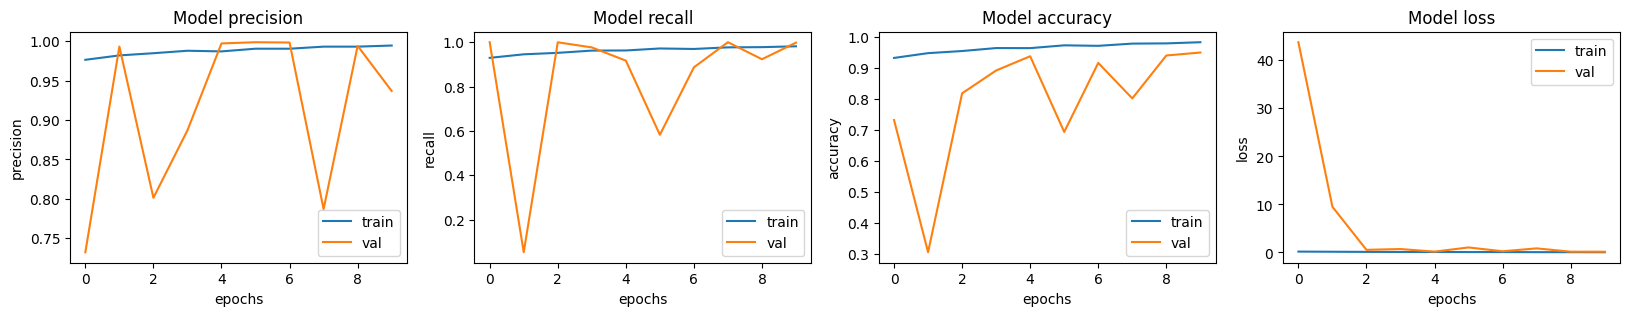

In [103]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [104]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

62/62 [==============================] - 2s 27ms/step - loss: 0.2732 - accuracy: 0.9201 - precision: 0.8968 - recall: 0.9951
Loss: 0.27316030859947205,
Accuracy: 0.9200652241706848,
Precision: 0.8968166708946228,
Recall: 0.9951279163360596
